### Libraries

In [1]:
import importlib

import config as Config
import constants.labels as Labels
import hangar.FirmBomberFactory as FirmBomberFactory
import hangar.FundBomberFactory as FundBomberFactory
import hangar.DisplayModule as DisplayModule
import models.firm as FirmModel
import models.funding as FundingModel
import models.investor as InvestorModel
import models.macro as MacroModel
import utils.dataframe as dfUtils
import utils.date as DateUtils
import utils.file as FileUtils
import utils.industry as IndustryUtils
import utils.visualiser as Visualiser
import utils.tests as Tests

def reload():
  importlib.reload(Config)
  importlib.reload(DateUtils)
  importlib.reload(Visualiser)
  importlib.reload(DisplayModule)
  importlib.reload(Tests)
  importlib.reload(FirmBomberFactory)
  importlib.reload(FundBomberFactory)

### Configuration
Configuration specified in src/config.js to avoid passing the same configurations around. Modify configurations as required, then run reload() to reload configurations without restarting the environment.

### Load Data
Data obtained from Crunchbase and CEIC (for macro data), preprocessed, then stored in pickle files. This section retrieves the stored data and does additional preprocessing.

#### Load Investor Data

In [2]:
# Read Investor Data
investors = FileUtils.read_pickle(f"investors")

In [3]:
# Get Public Funded Investors
public_funded_investors = InvestorModel.get_public_funded_investors(investors)

#### Load Company Data

In [4]:
# Read Company Data
firms = FileUtils.read_pickle(f"{Config.country}_firms")

In [5]:
# Read Domain Data
domain_created_year = FileUtils.read_pickle('domain_created_year')

In [6]:
# Filter and Enrich Company Data
firms = FirmModel.filter_for_profit(firms)
firms = FirmModel.enrich_founded_year(firms, domain_created_year)
firms = FirmModel.filter_founded_year(firms, Config.start_year, Config.end_year)
firms = FirmModel.enrich_public_funded(firms, public_funded_investors)
firms = firms.reset_index(drop=True)

#### Load Funding Data

In [7]:
# Read Funding Data
funding = FileUtils.read_pickle(f"funding")

In [8]:
# Filter and Enrich Funding Data
funding = FundingModel.filter_announced_year(funding, Config.start_year, Config.end_year)
funding = FundingModel.enrich_public_funded(funding, public_funded_investors)

#### Load Macro Data

In [9]:
# Read Macro Data
real_gdp = FileUtils.read_pickle('real_gdp')
fed_rate = FileUtils.read_pickle('fed_rate')

In [10]:
# Filter Macro Data
real_gdp = real_gdp['United States']
real_gdp = real_gdp[real_gdp.index >= Config.start_year]
real_gdp = real_gdp[real_gdp.index < Config.end_year]

fed_rate = fed_rate['Fed Rate']
fed_rate = fed_rate[fed_rate.index >= Config.start_year]
fed_rate = fed_rate[fed_rate.index < Config.end_year]

In [11]:
# Store Macro Data
macro = MacroModel.Macro(real_gdp, fed_rate)

### Load Other Data

In [12]:
# Industry Labels
industry_groups = IndustryUtils.get_industry_groups()
industries = IndustryUtils.get_industries()

### Preprocess Data

In [13]:
# Load Bombers
# reload()
firm_bomber_ig = FirmBomberFactory.FirmBomber(firms, targets=industry_groups, target_col=Labels.industry_groups)
firm_bomber_i = FirmBomberFactory.FirmBomber(firms, targets=industries, target_col=Labels.industries)

In [14]:
# Load Bombers
# reload()
fund_bomber_ig = FundBomberFactory.FundBomber(funding, targets=industry_groups, target_col=Labels.industry_groups)
fund_bomber_i = FundBomberFactory.FundBomber(funding, targets=industries, target_col=Labels.industries)

### Plots

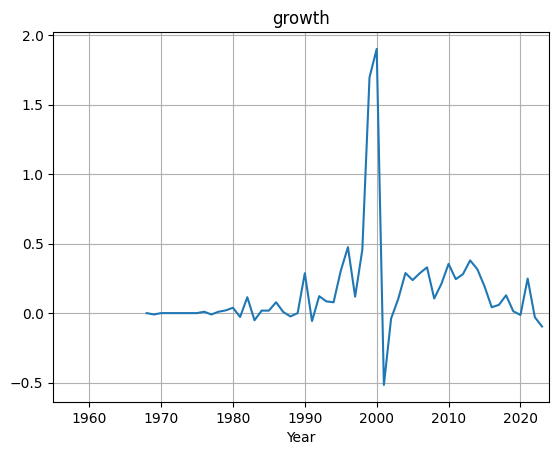

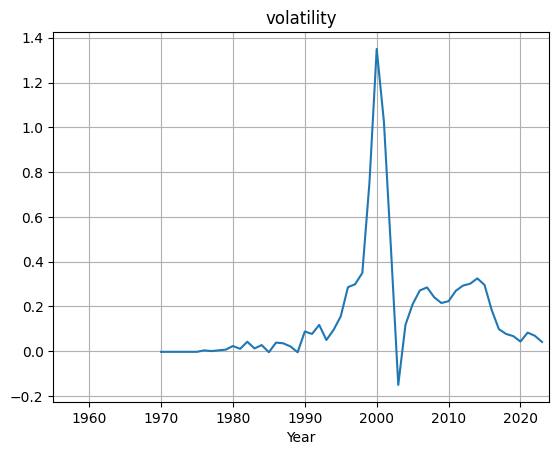

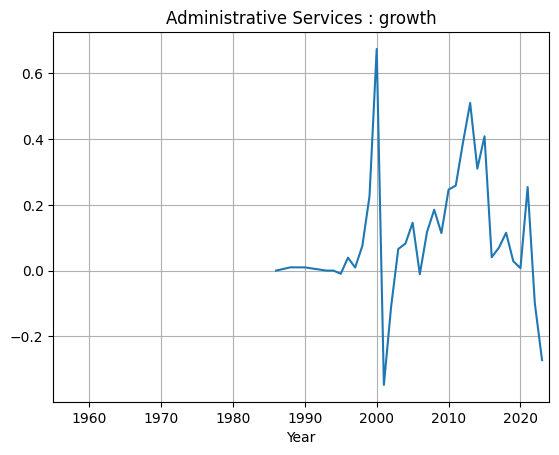

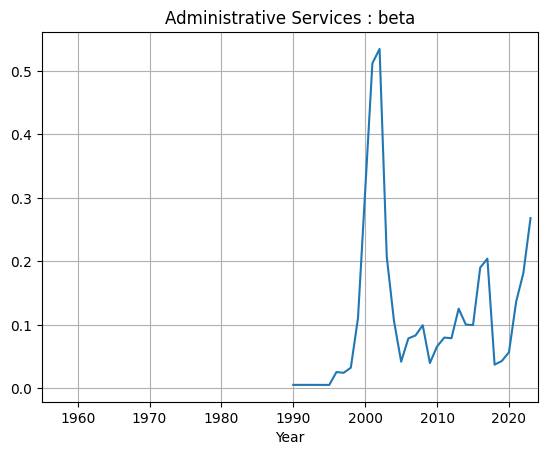

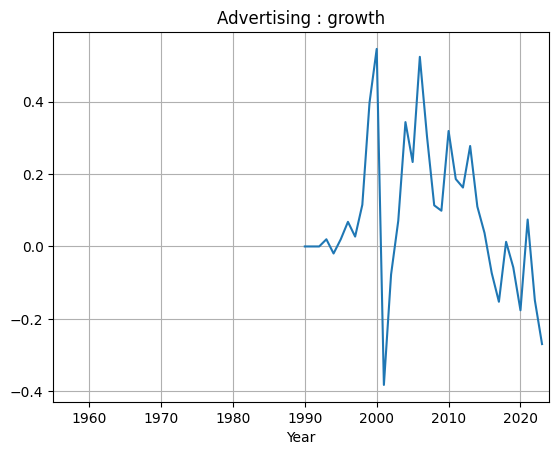

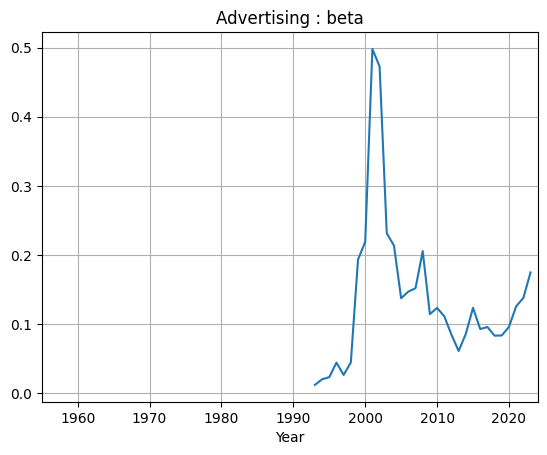

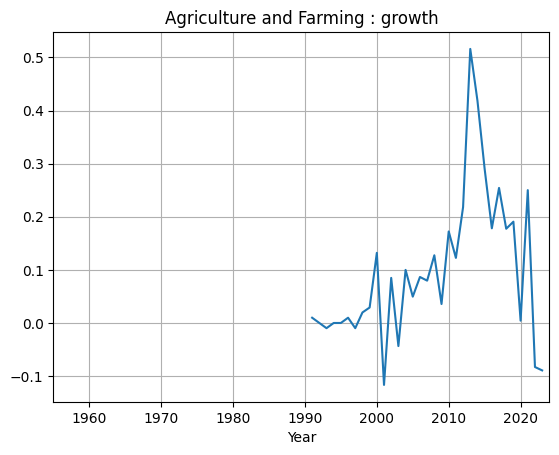

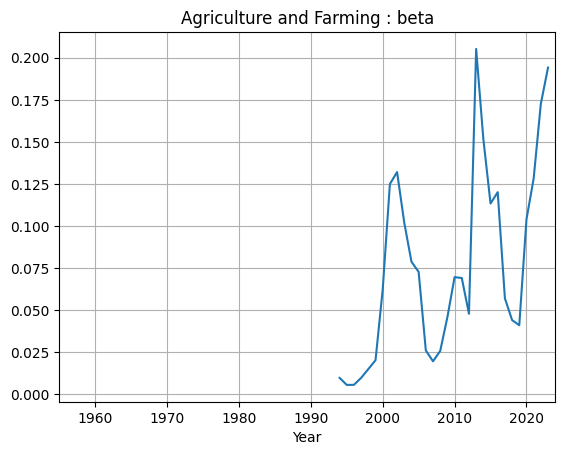

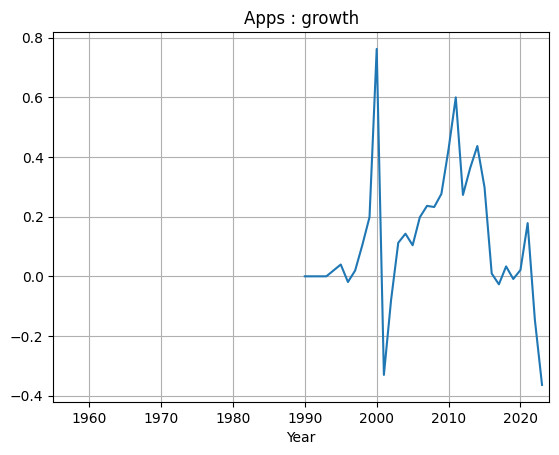

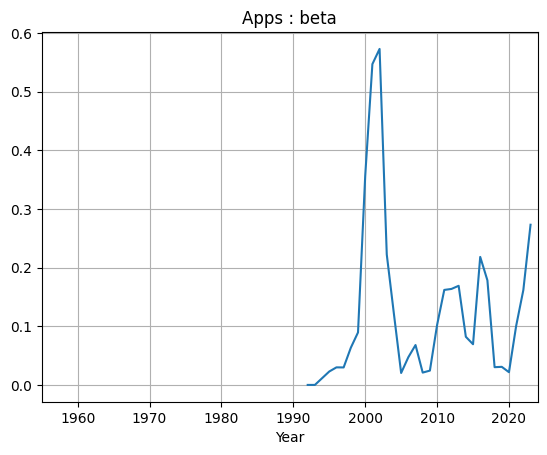

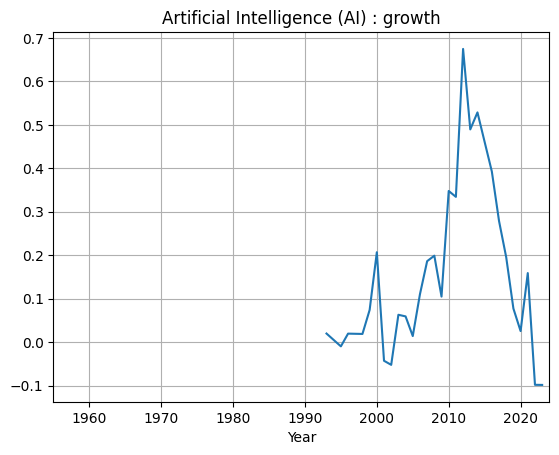

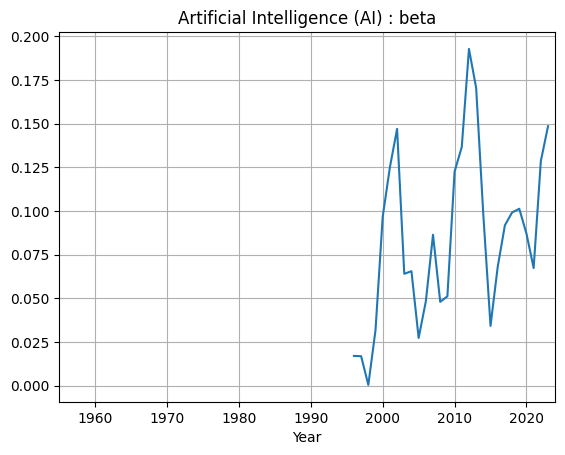

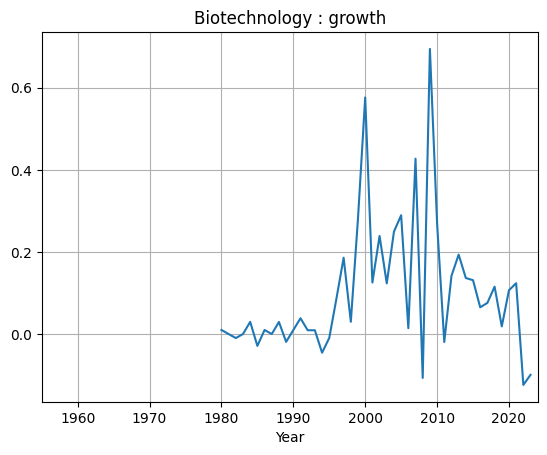

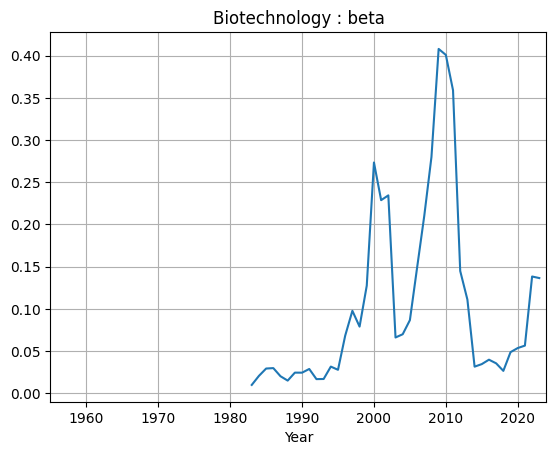

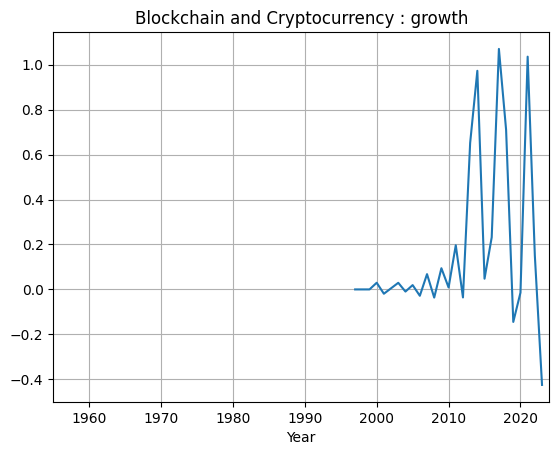

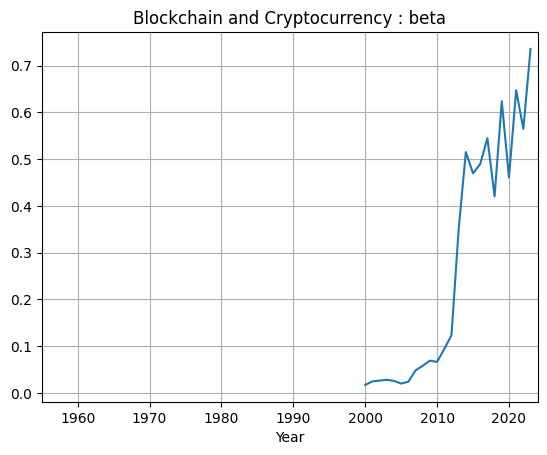

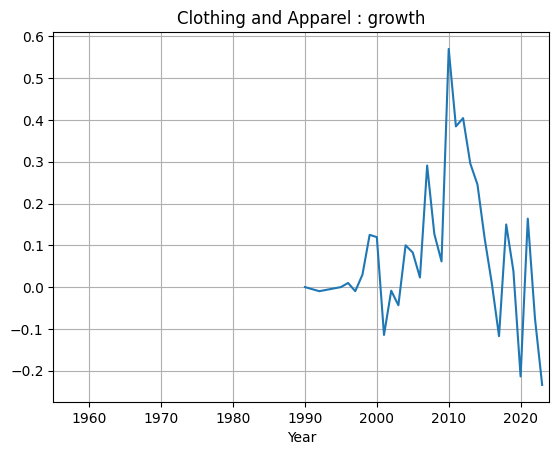

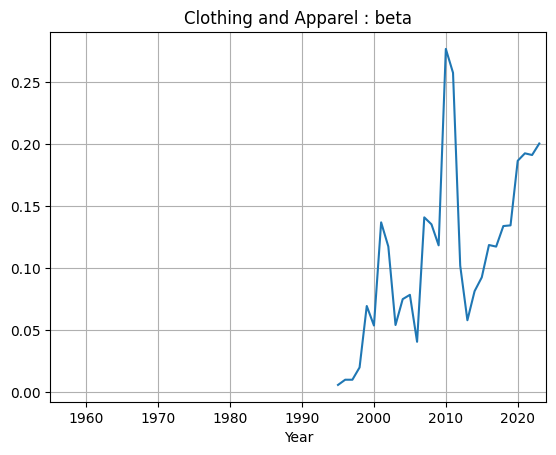

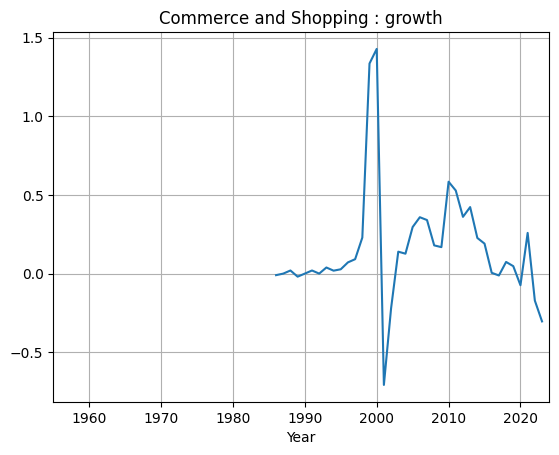

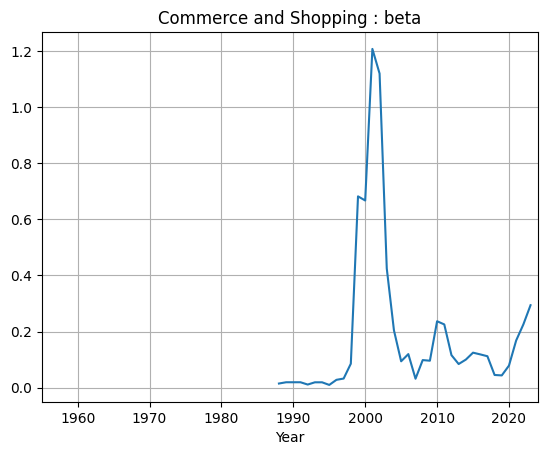

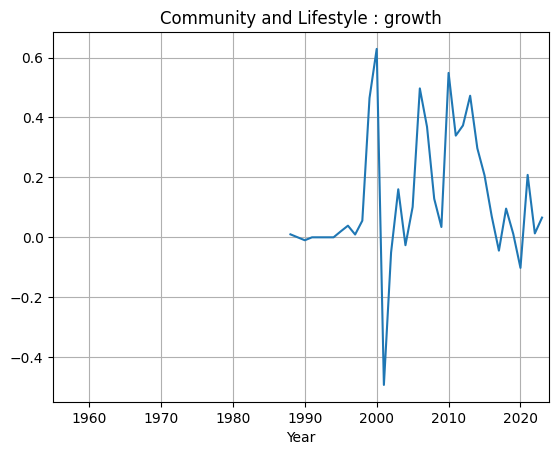

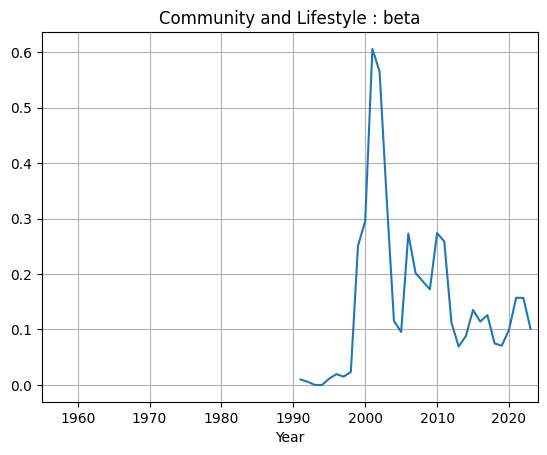

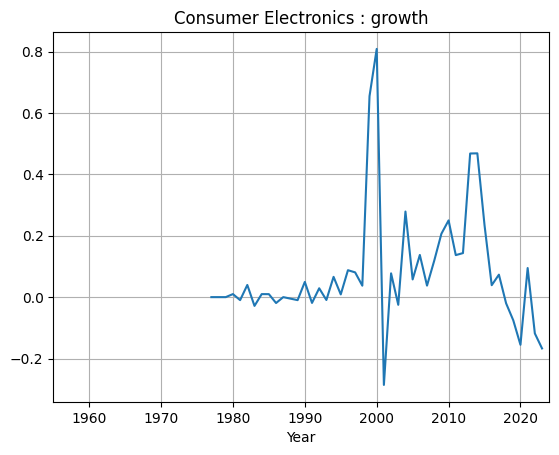

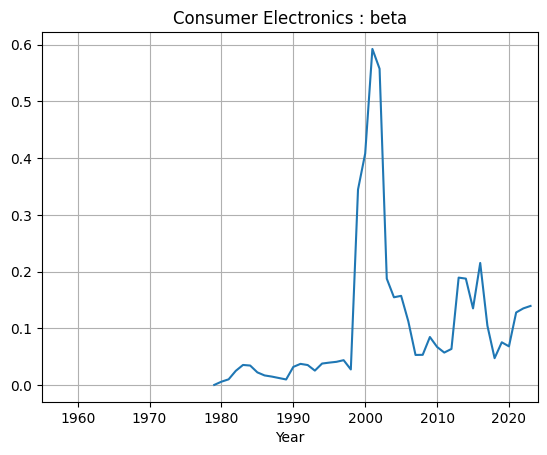

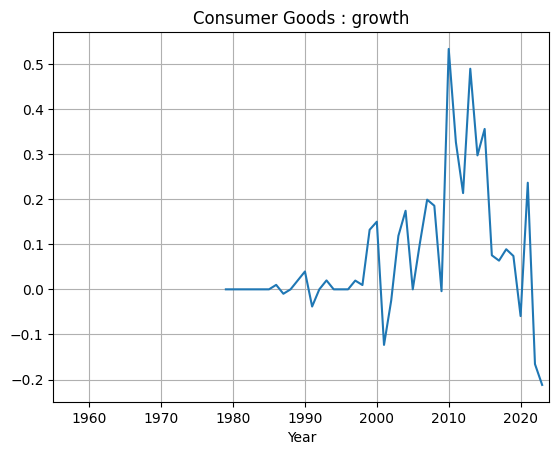

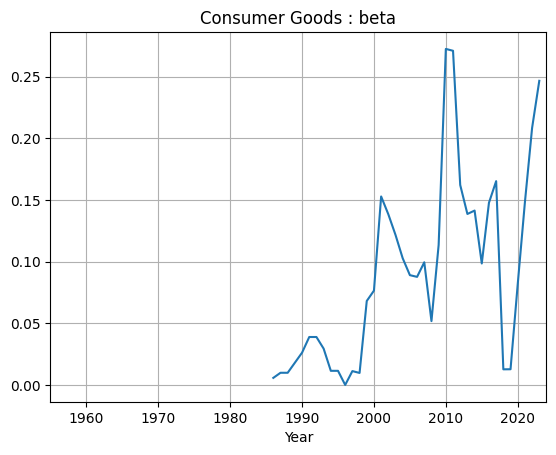

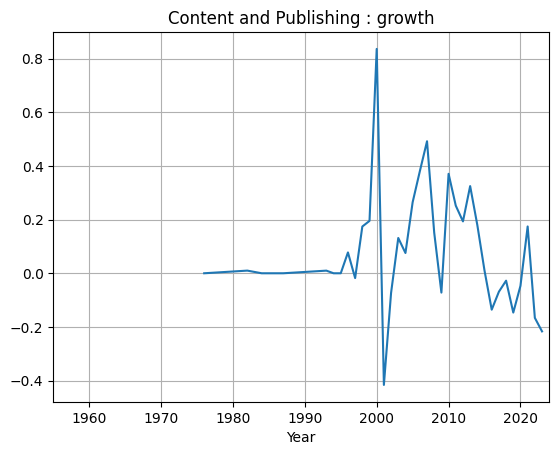

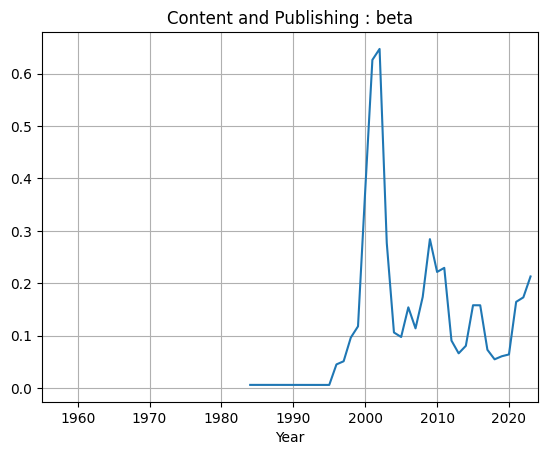

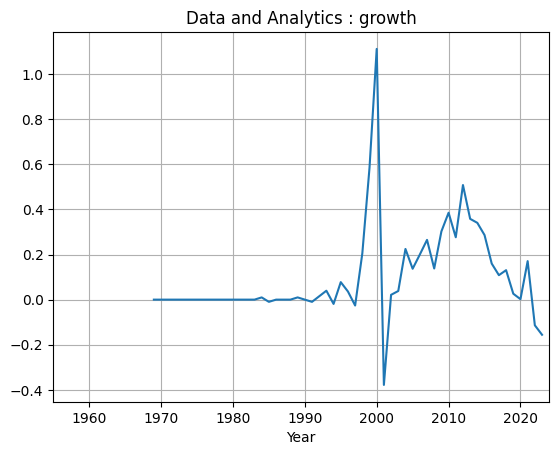

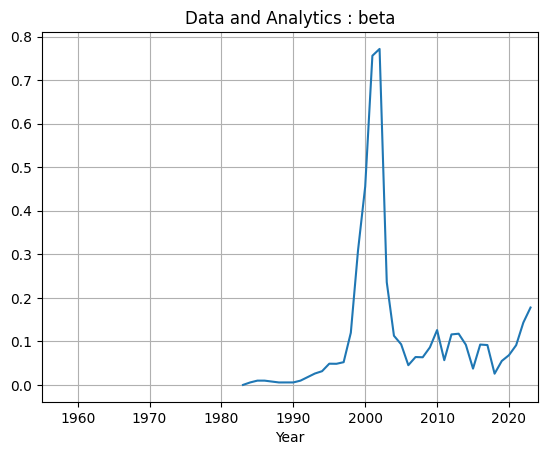

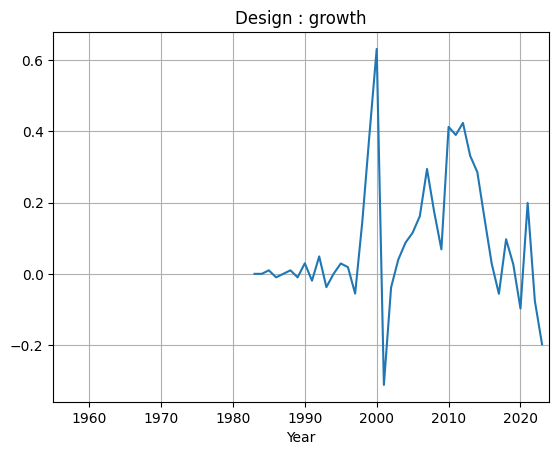

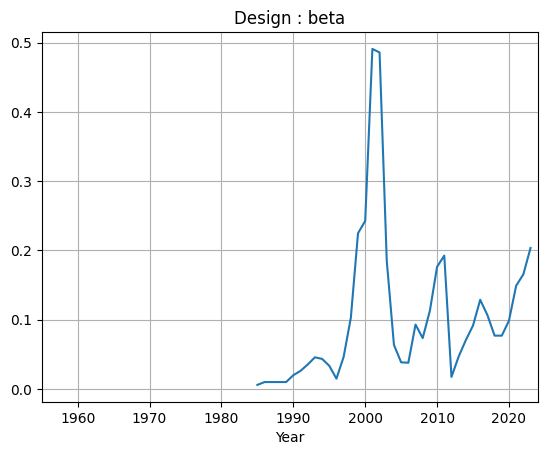

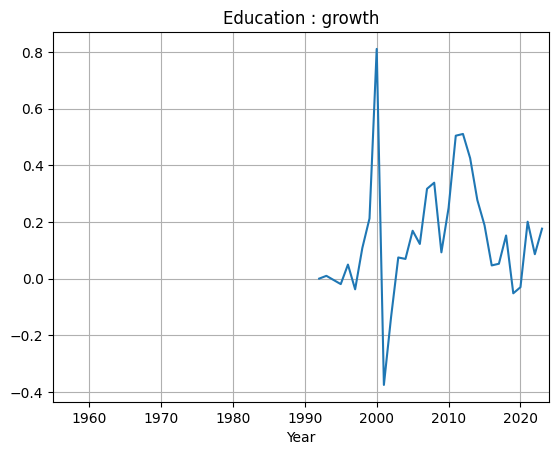

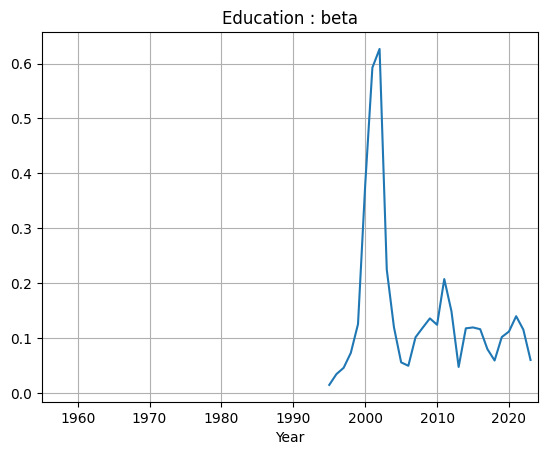

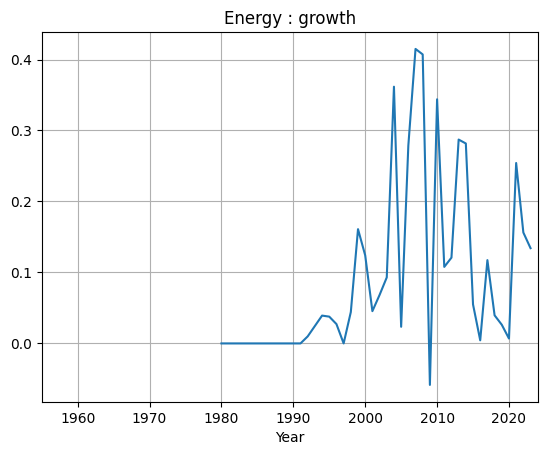

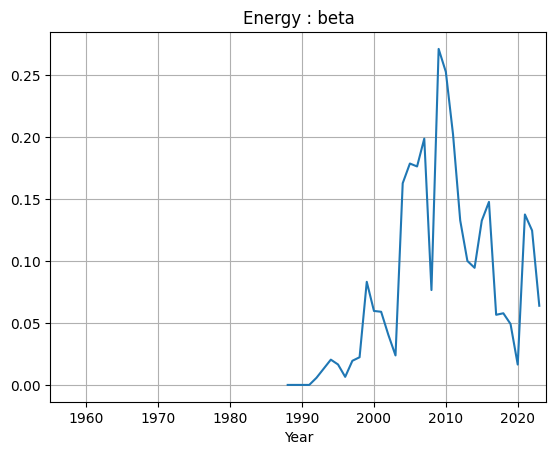

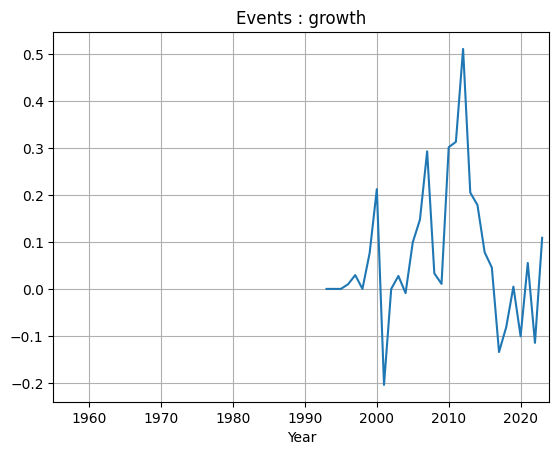

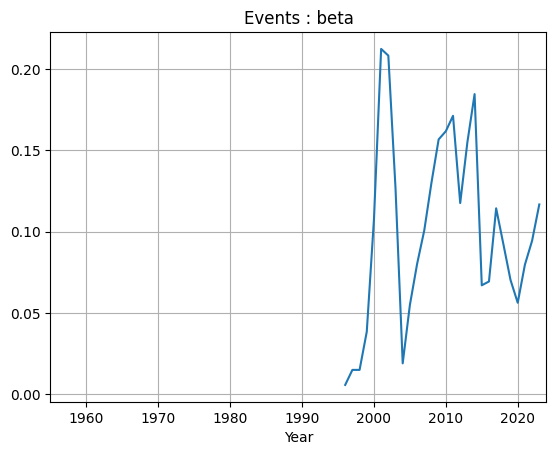

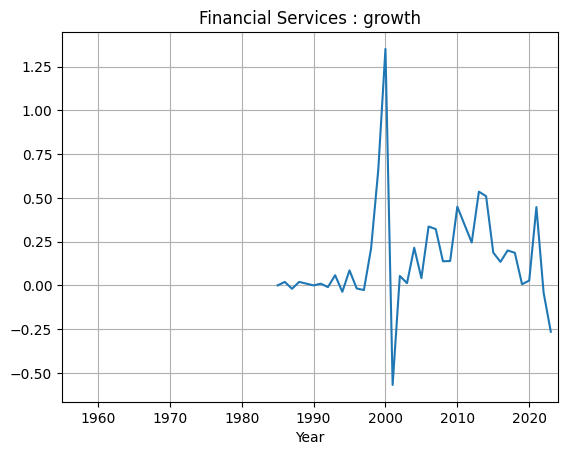

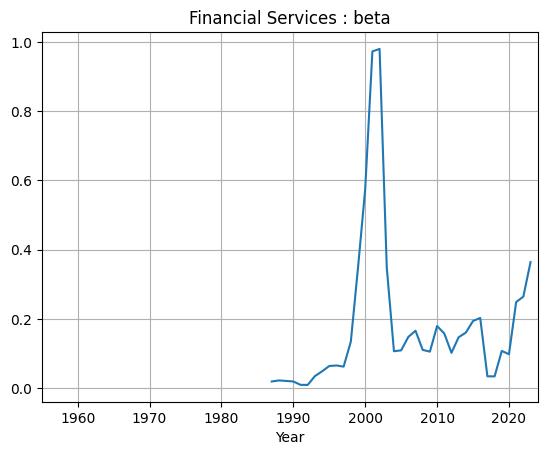

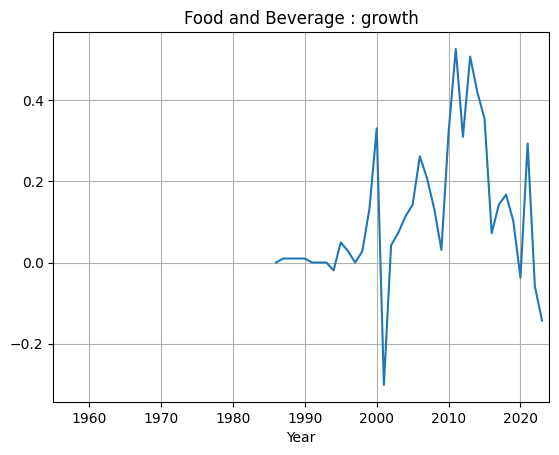

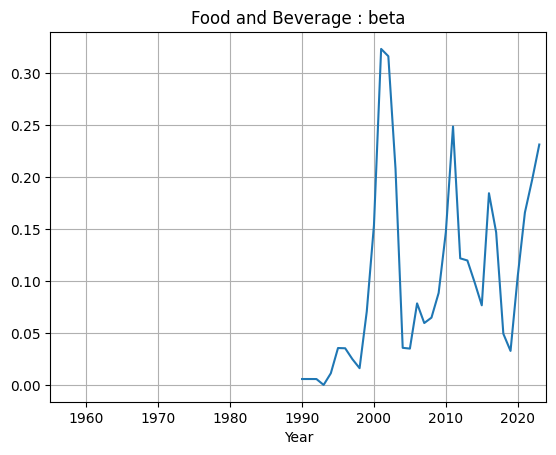

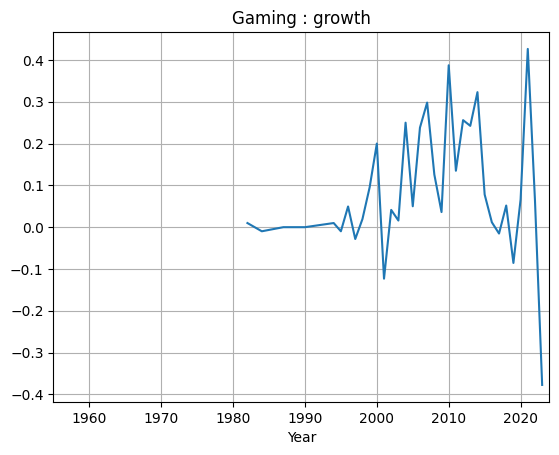

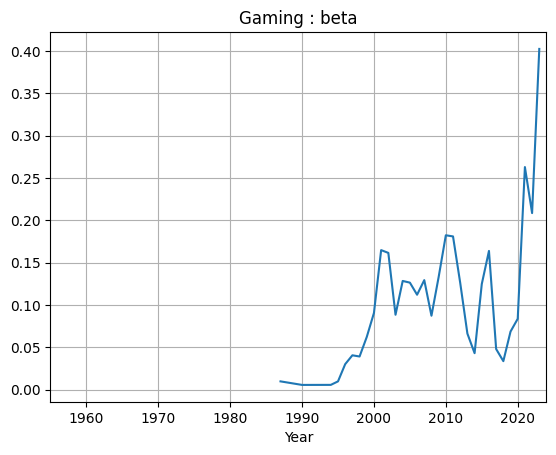

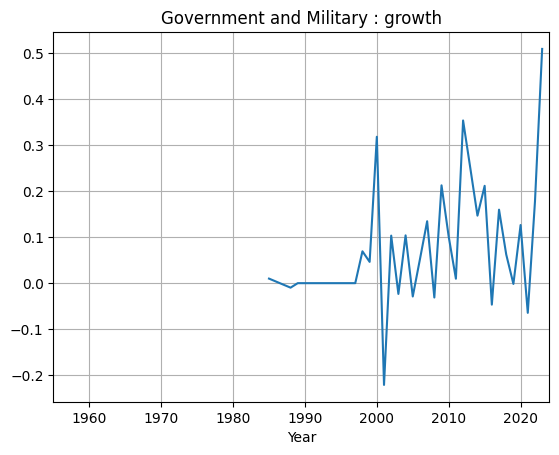

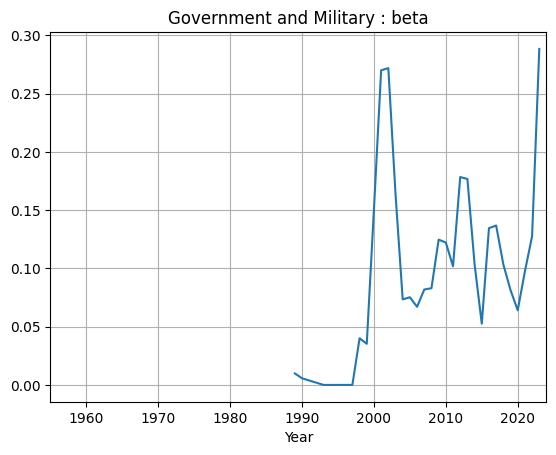

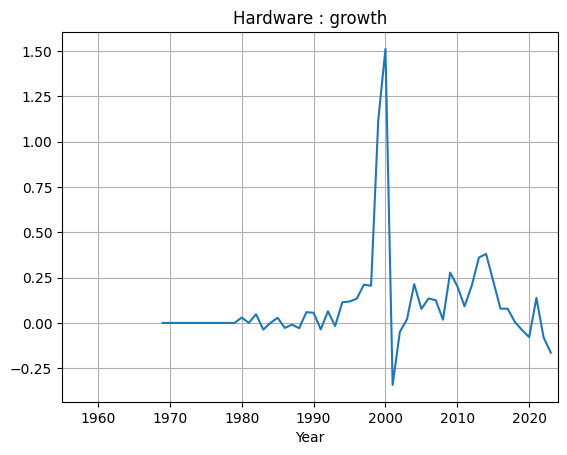

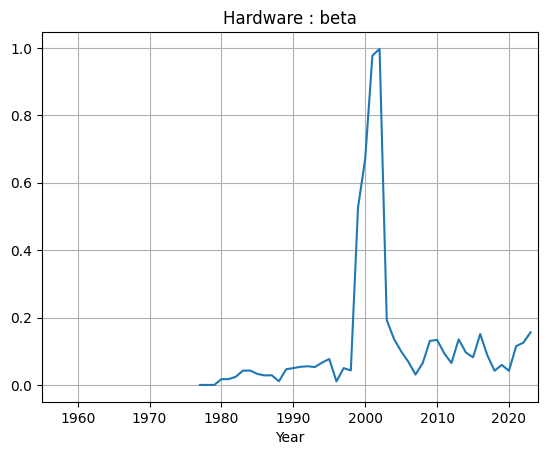

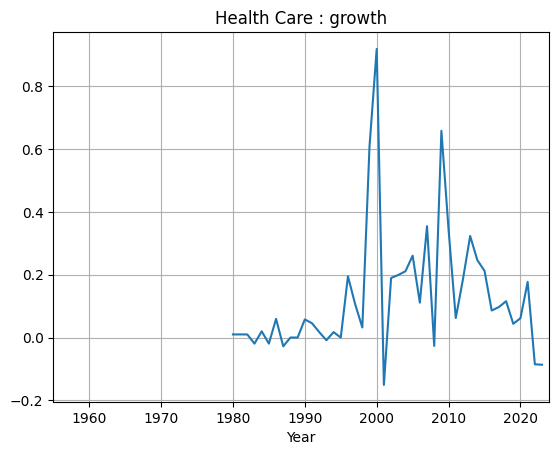

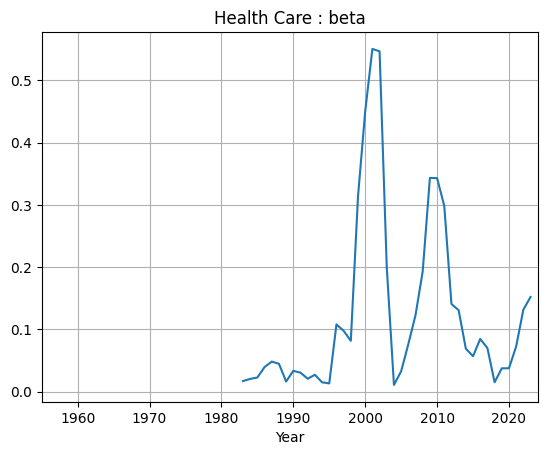

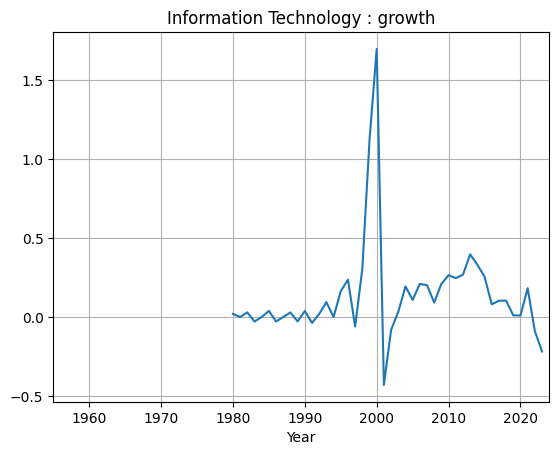

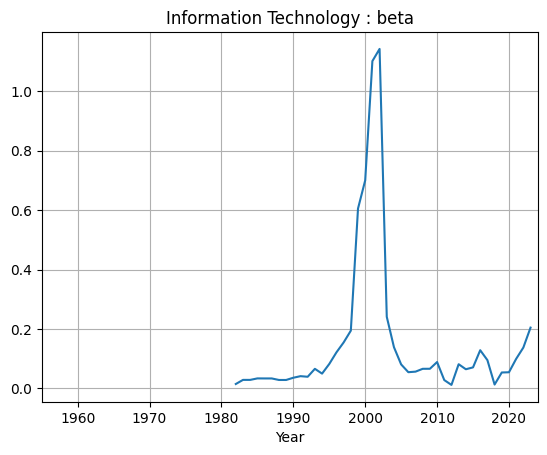

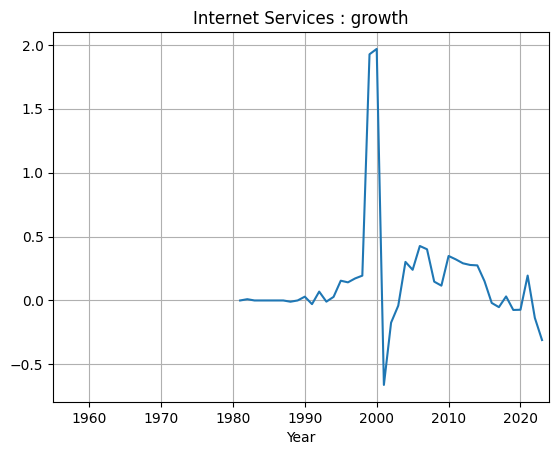

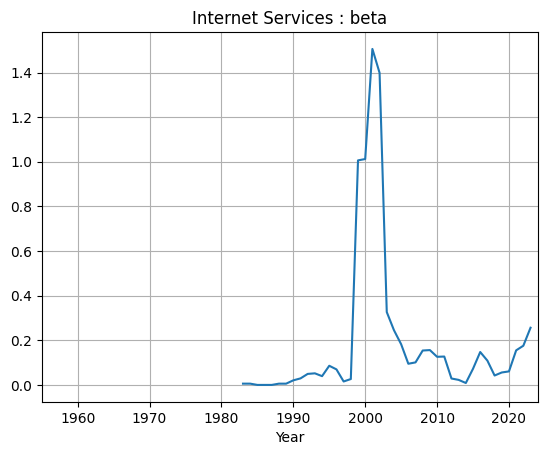

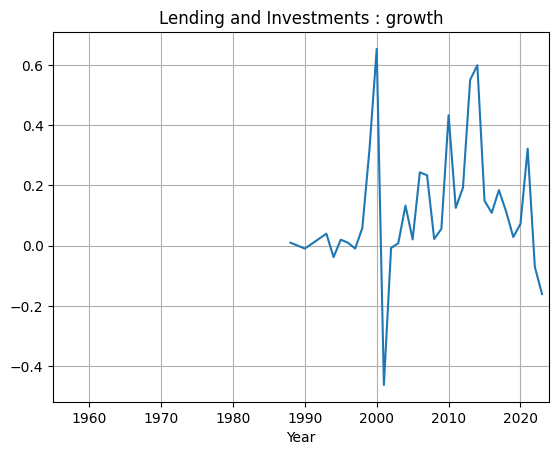

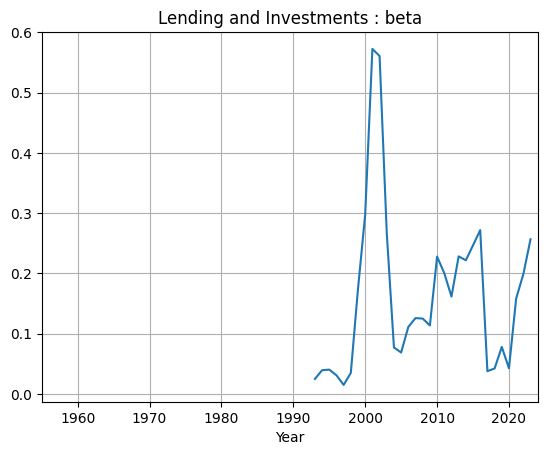

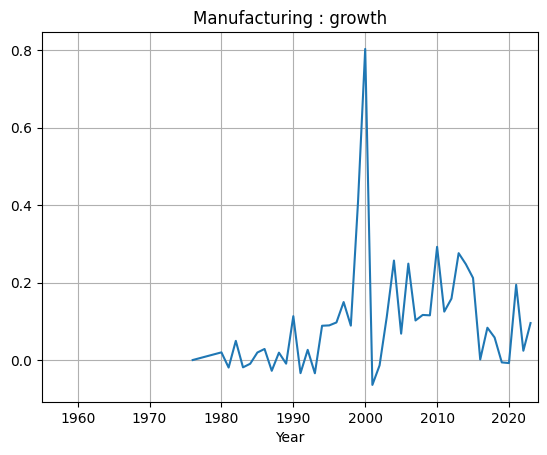

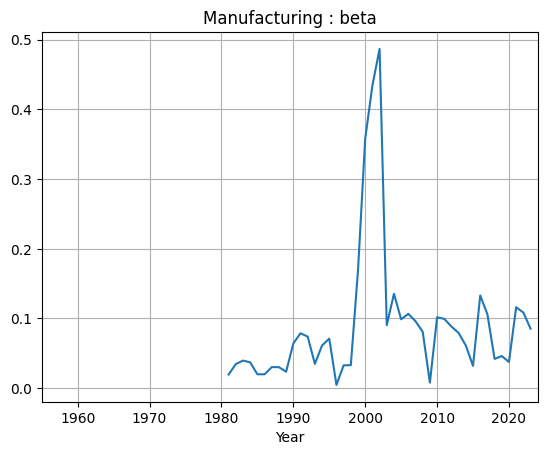

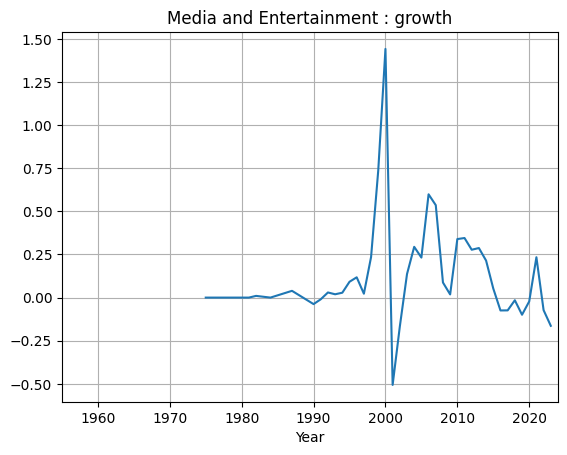

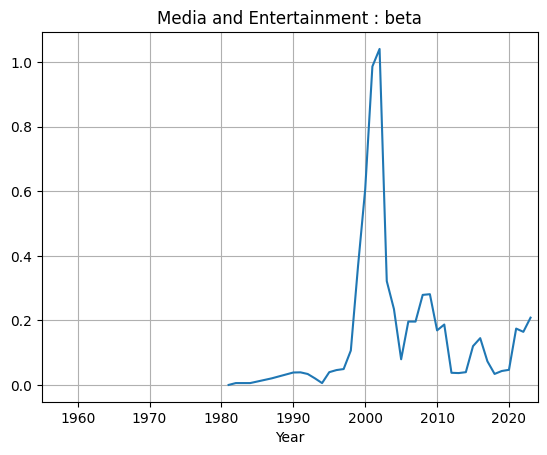

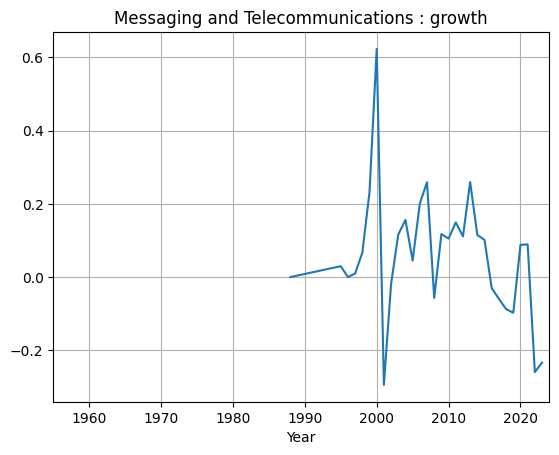

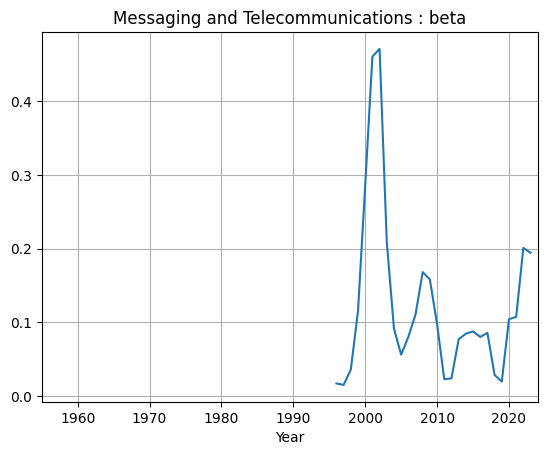

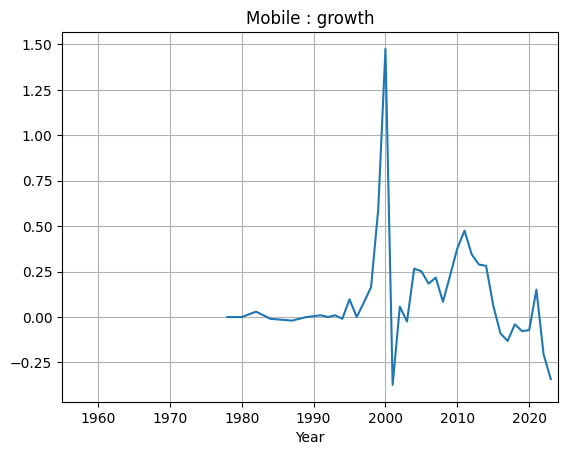

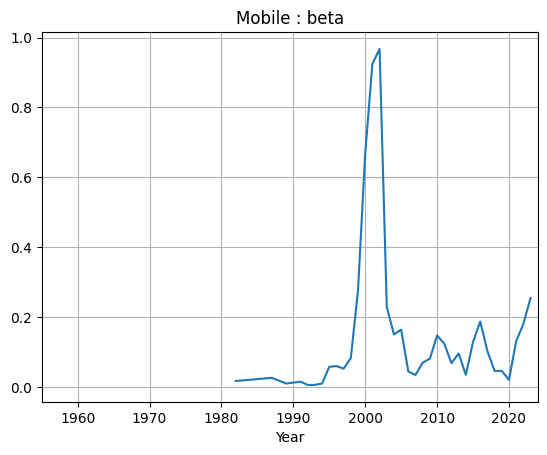

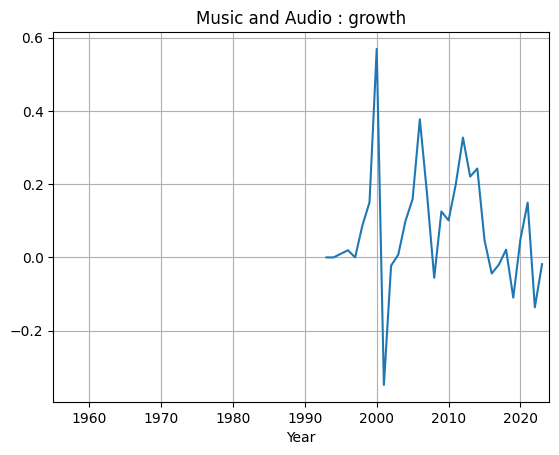

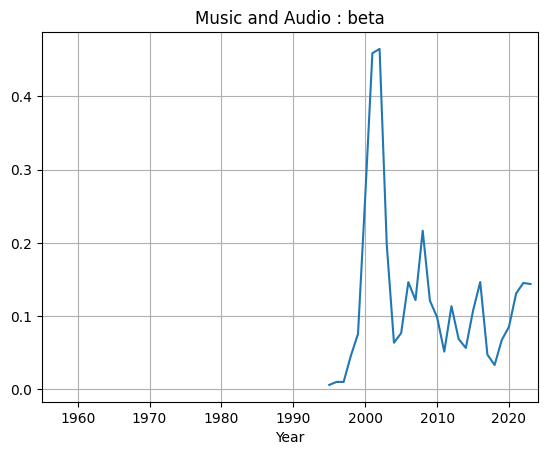

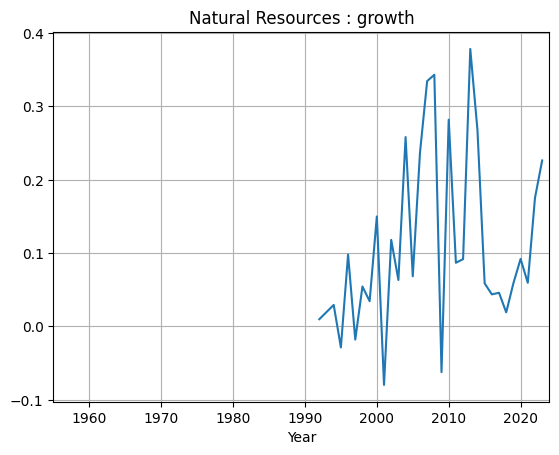

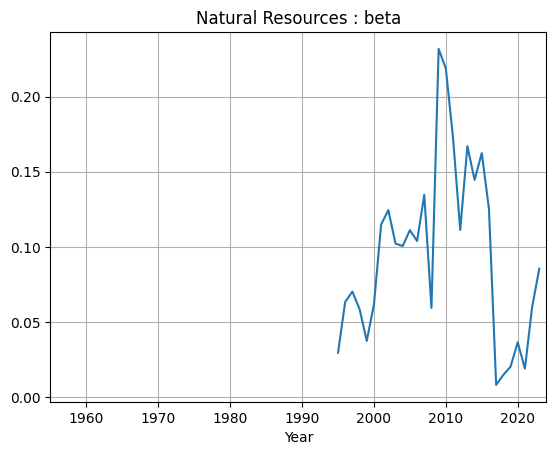

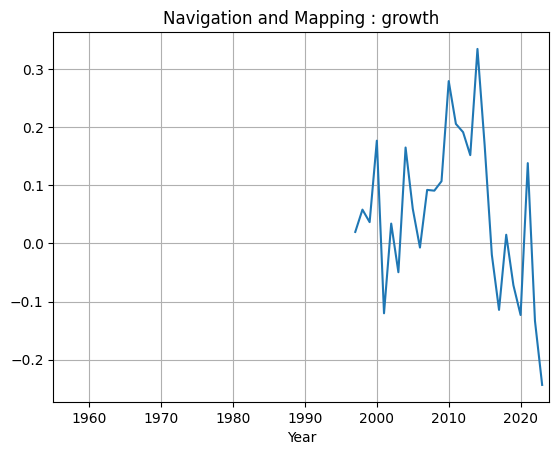

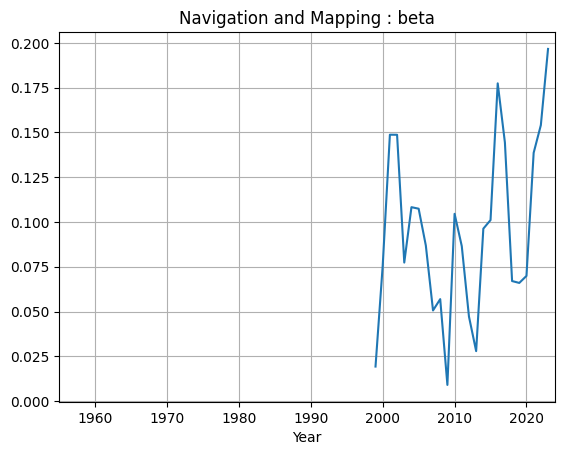

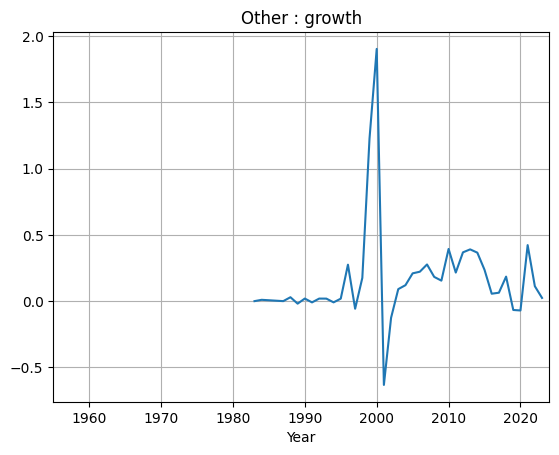

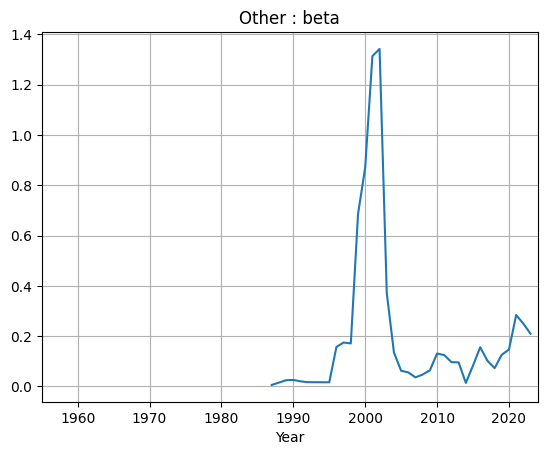

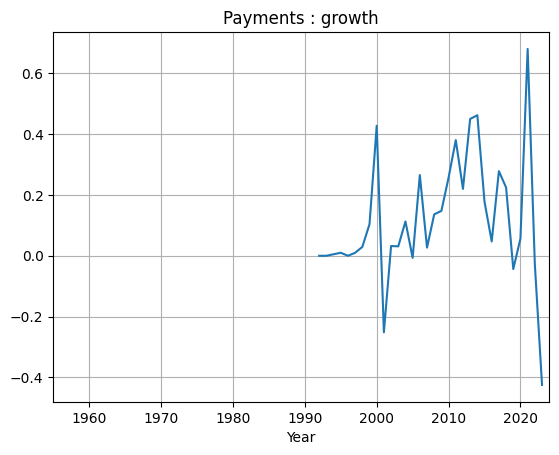

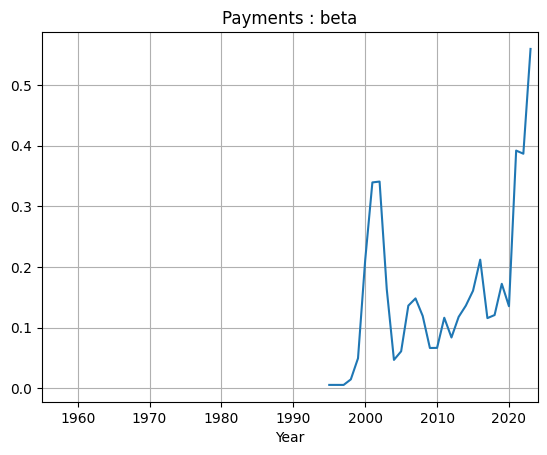

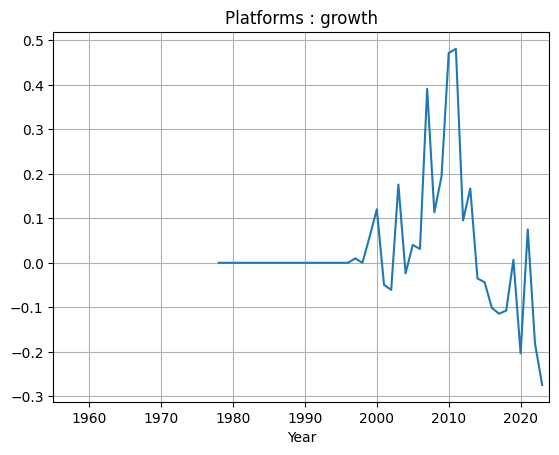

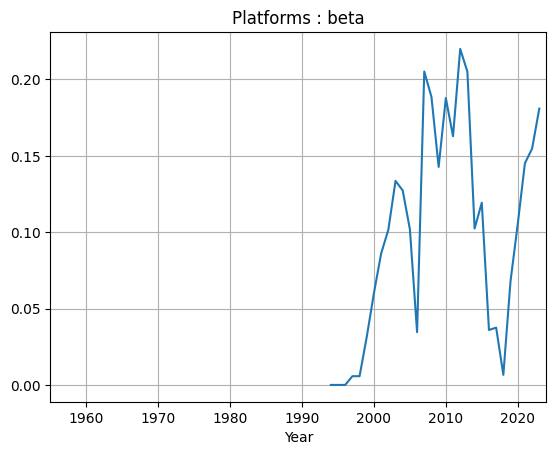

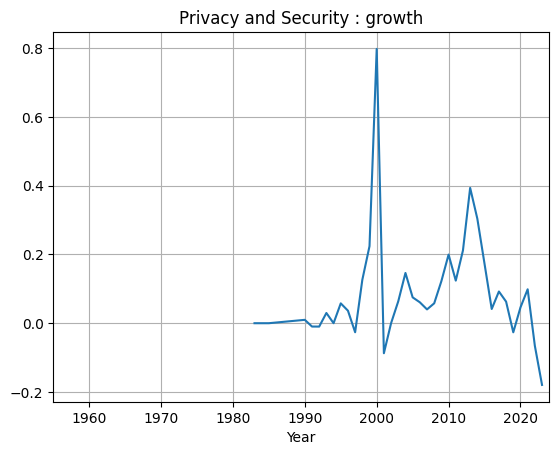

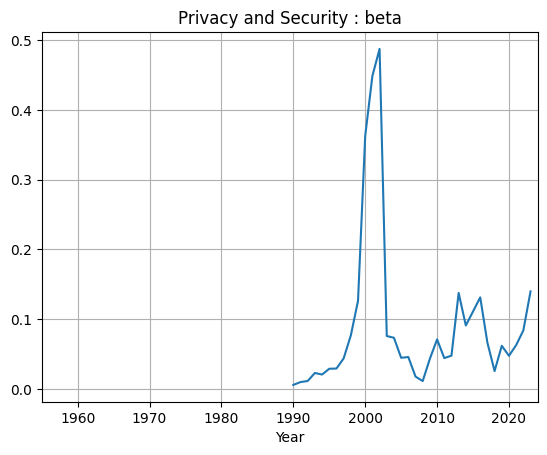

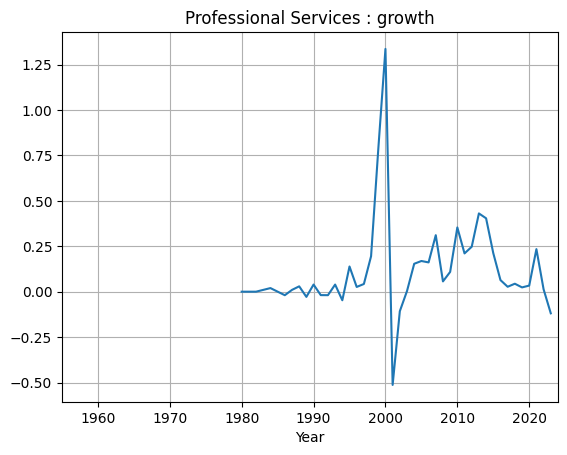

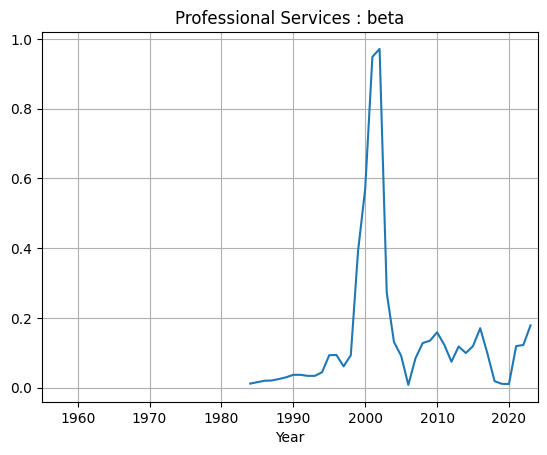

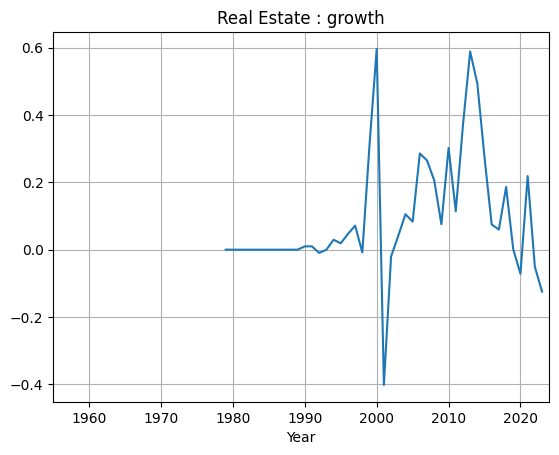

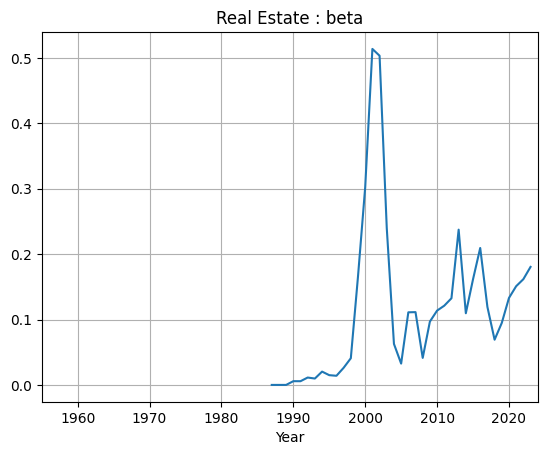

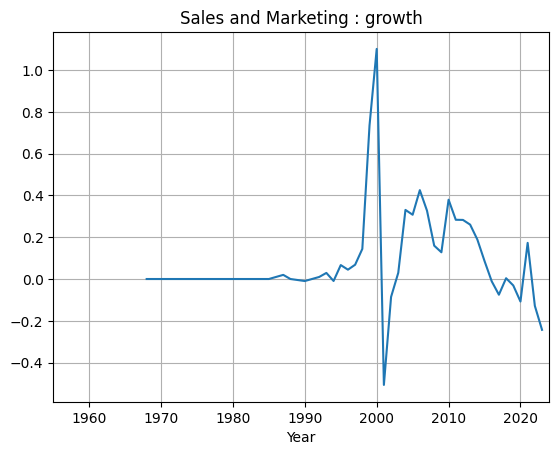

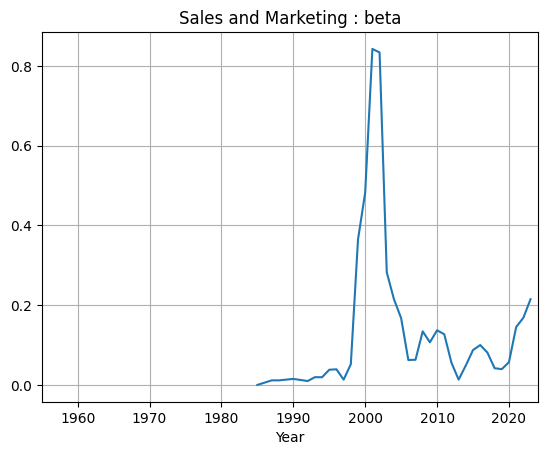

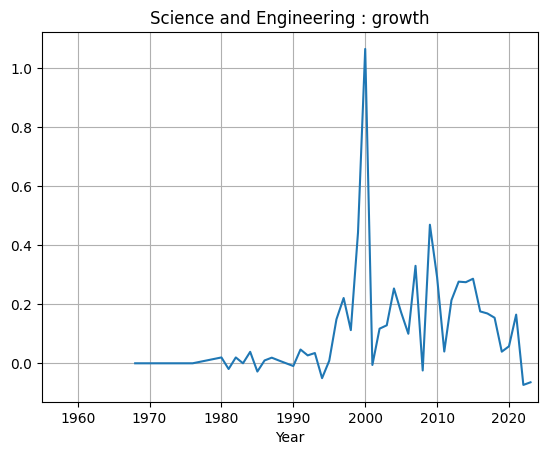

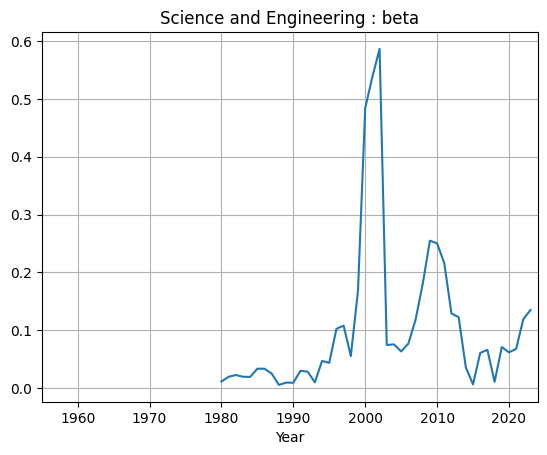

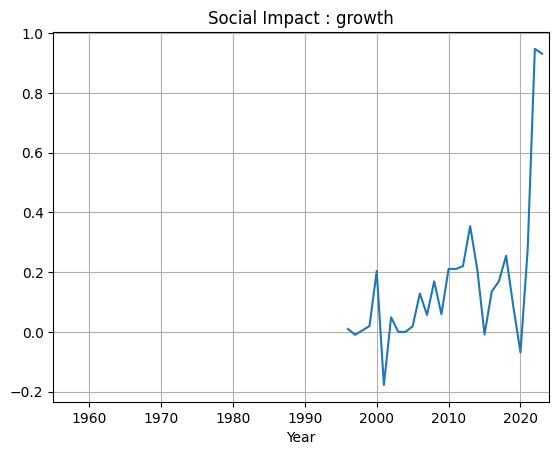

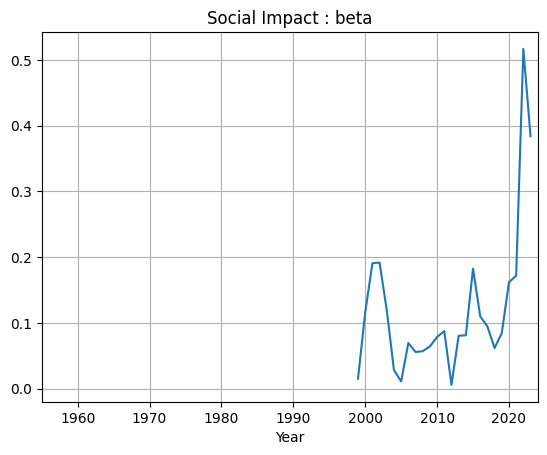

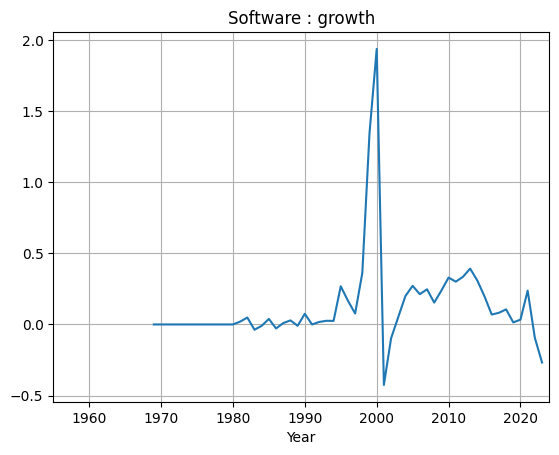

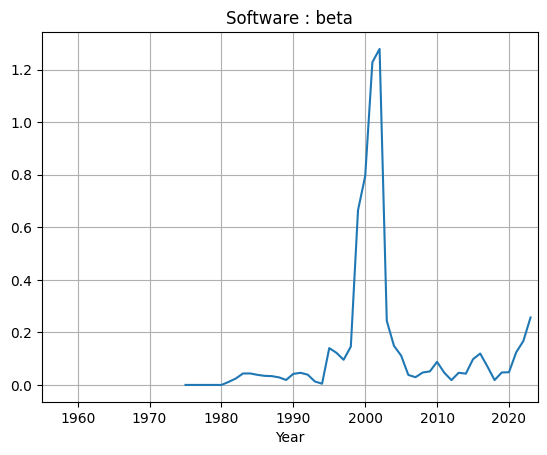

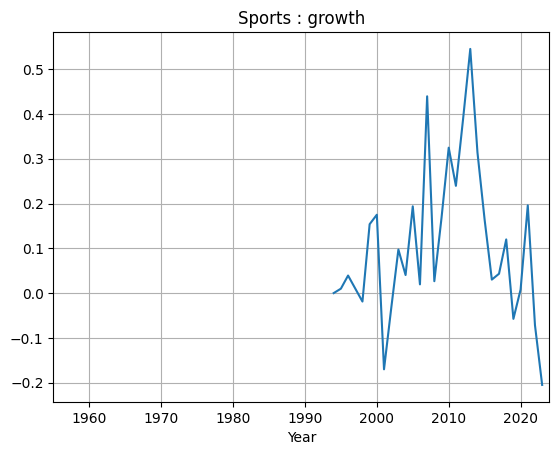

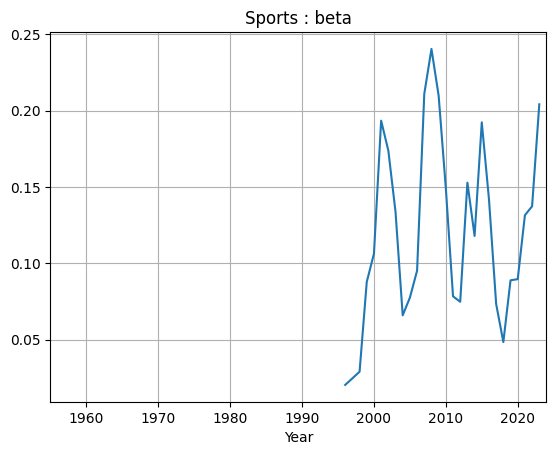

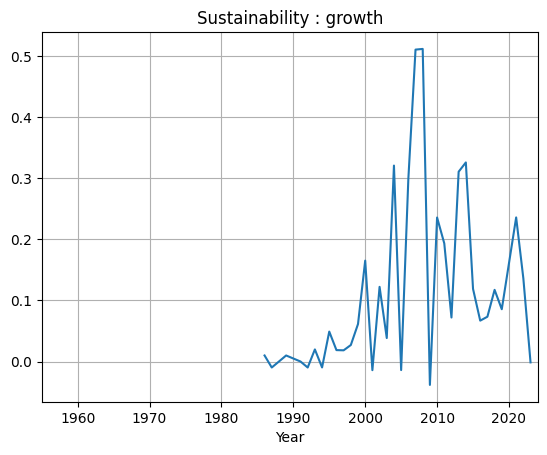

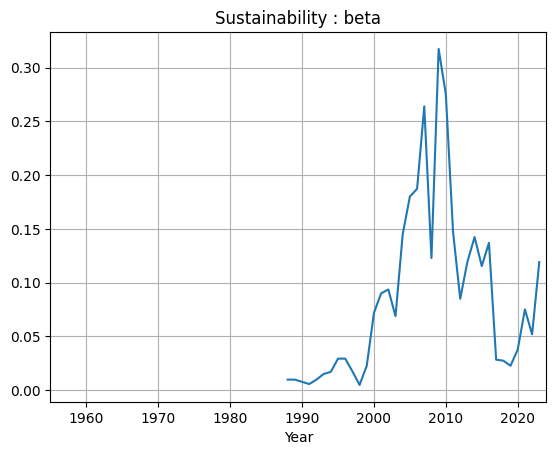

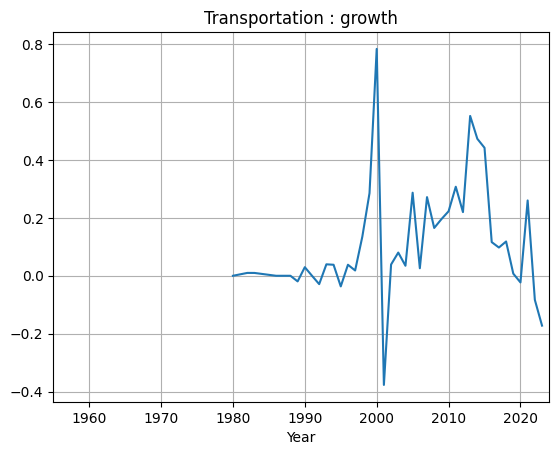

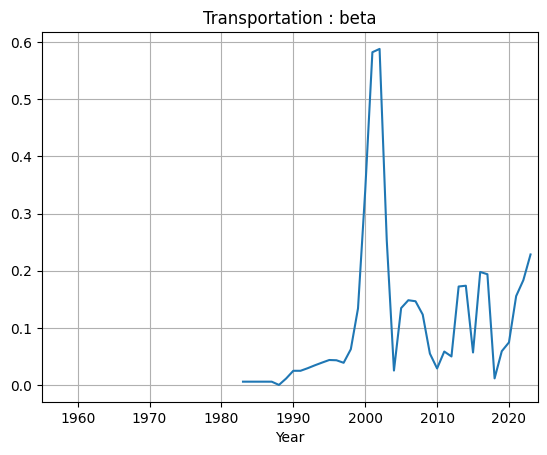

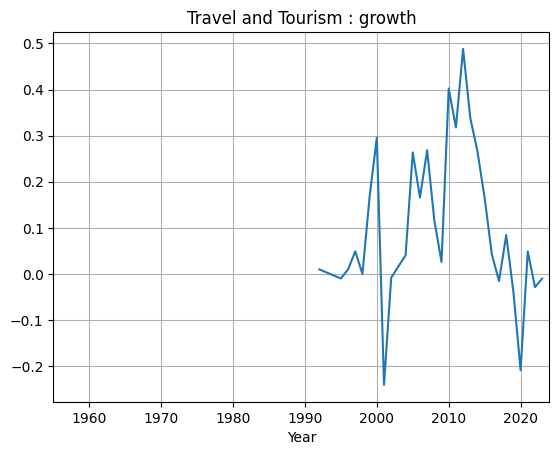

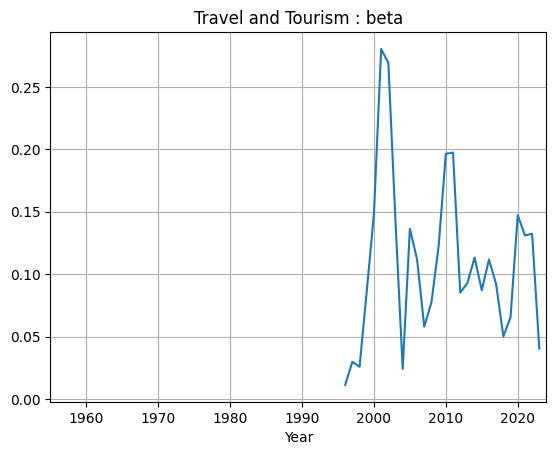

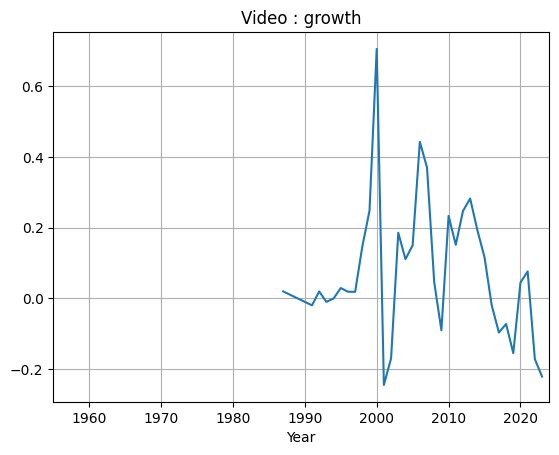

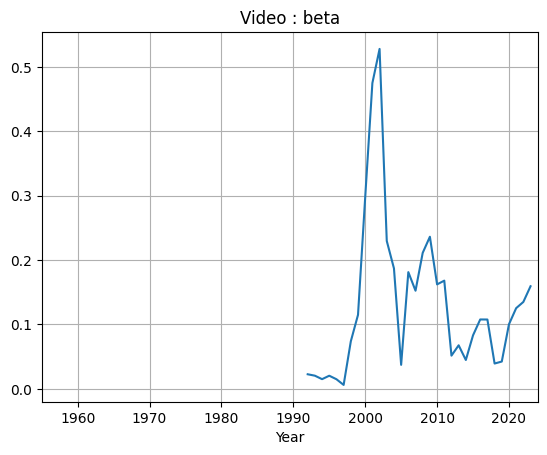

In [17]:
# reload()

# Visualiser.plot(fund_bomber_ig.year_count_growth, 'growth')
# Visualiser.plot(fund_bomber_ig.year_volatility, 'volatility')

# for key, series in fund_bomber_ig.year_count_growth_map.items(): 
#   Visualiser.plot(fund_bomber_ig.year_count_growth_map[key], f'{key} : growth')
#   Visualiser.plot(fund_bomber_ig.year_count_growth_beta_map[key], f'{key} : beta')

In [16]:
reload()

targets = []
# Convert data to data frame for panel regression

# beta_map = firm_bomber_ig.year_count_growth_beta_abs_map
# beta_map = firm_bomber_i.year_count_growth_beta_abs_map
beta_map = fund_bomber_ig.year_count_growth_beta_map
# beta_map = fund_bomber_i.year_count_growth_beta_abs_map

# beta_map = fund_bomber_ig.year_count_growth_beta_map
# beta_map = fund_bomber_i.year_count_growth_beta_map
# beta_map = firm_bomber_ig.year_count_growth_beta_map
# beta_map = firm_bomber_i.year_count_growth_beta_map

df = dfUtils.map_to_df(beta_map)
df = Tests.prep_panel(df, macro.fed_rate, 'fed_rate')

results = Tests.panel(df, 'fed_rate')

results:                           PanelOLS Estimation Summary                           
Dep. Variable:                  value   R-squared:                        0.0691
Estimator:                   PanelOLS   R-squared (Between):              1.0000
No. Observations:                1679   R-squared (Within):               0.0254
Date:                Wed, Mar 06 2024   R-squared (Overall):              0.0691
Time:                        19:45:32   Log-likelihood                    662.79
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      2.4160
Entities:                          49   P-value                           0.0000
Avg Obs:                       34.265   Distribution:                 F(50,1628)
Min Obs:                       23.000                                           
Max Obs:                       48.000   F-statistic (robust):          2.549e+18
                   